In [1]:
# main file that includes all relevant sph functionality
from sph import *

# main file that includes all learning relevant functionality, not necessary to understand
from torch.optim import Adam
from rbfConv import *
from torch_geometric.loader import DataLoader

# plotting/UI related imports
import matplotlib as mpl
plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']
from tqdm.notebook import trange, tqdm
%matplotlib notebook

In [2]:
numParticles = 2048 # set up here as PDF sampling and noise functions use this parameter

# different initial starting conditions, just pick one
# sinusoidal sampling
# pdf = lambda x: np.sin(x * np.pi * 4) + 2
# (excessive) sawtooth profile with step at x = 1 that has 0 density at x=-1 (barring periodic BC)
# pdf = lambda x: 1 + x
# square wave sampling
def pdf(x):
    out = np.array(np.ones_like(x) * 2)
    out[np.abs(x) > 1/3] = 1
    return out
# sawtooth profile with step at x = 1 with at least a density of 1 everywhere
# def pdf(x):
#     x = np.array(x)
#     out = np.array(np.ones_like(x))
#     out[x > 0] = x[x>0] + 0
#     out[x < 0] = x[x<0] + 2
#     return out + 1
# triangular density profile with peaks at x=-1 and x=1
# pdf = lambda x: np.abs(x) + 1
# gaussian density profile with narrow peak
# pdf = lambda x: 1 + np.exp(-(x * 8)**2) * 2
# uniform density profile, mostly for debugging
# pdf = lambda x: np.ones_like(np.array(x))
# octave noise based on perlin noise
# noise  = 2 + generate1DPeriodicNoise(numSamples = numParticles, r = 0.75, freq = 1, octaves = 4, plot = False, seed = 1234) * 0.25
# pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)
# low frequency sinusoidal sampling,  mostly to test the interp process
# noise = 2 + np.sin(np.linspace(-np.pi, np.pi, numParticles))
# pdf = lambda x : np.interp(x, np.linspace(-1,1,numParticles), noise)

In [3]:
# SPH simulation step, returns dudt, dxdt as well as current density and pressure
def computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphCoefficient, particleSupport, dt):
    #  1. Create ghost particles for our boundary conditions
    ghostPositions = createGhostParticles(fluidPositions, minDomain, maxDomain)
    #  2. Find neighborhoods of all particles:
    fluidNeighbors, fluidRadialDistances, fluidDistances = findNeighborhoods(fluidPositions, ghostPositions, particleSupport)
    #  3. Compute \rho using an SPH interpolation
    fluidDensity = computeDensity(fluidPositions, fluidAreas, particleSupport, fluidRadialDistances, fluidNeighbors)
    #  4. Compute the pressure of each particle using an ideal gas EOS
    fluidPressure = (fluidDensity - 1.0) * kappa * restDensity
    #  5. Compute the XSPH term and apply it to the particle velocities:    
    xsphUpdate = computeXSPH(fluidPositions, fluidVelocities, fluidDensity, fluidAreas, particleSupport, xsphCoefficient, fluidNeighbors, fluidRadialDistances)
    #  6. Compute pressure forces and resulting acceleration
    fluidPressureForces = computePressureForces(fluidPositions, fluidDensity, fluidPressure, fluidAreas, particleSupport, restDensity, fluidNeighbors, fluidRadialDistances, fluidDistances)
    fluidAccel = fluidPressureForces # / (fluidAreas * restDensity)
    # 7. Compute kinematic viscosity
    laminarViscosity = computeDiffusion(fluidPositions, fluidVelocities, fluidAreas, fluidDensity, particleSupport, restDensity, diffusionCoefficient, fluidNeighbors, fluidRadialDistances, fluidDistances) # currently broken for some reason
    # fluidAccel += laminarViscosity
    fluidAccel += xsphUpdate / dt + laminarViscosity
    return fluidAccel, fluidVelocities, fluidDensity, fluidPressure

In [4]:
# simulation parameters
minDomain = -1 # minimum domain, leave at -1 for the most part
maxDomain = 1 # maximum domain, leave at 1 for the most part
# change base area to change initial starting density
baseArea = 2 / numParticles * 2
particleRadius = baseArea / 2.0
# change particle support to make simulation more/less smooth
particleSupport = particleRadius * 8.
# SPH parameters
xsphConstant = 0.1
diffusionCoefficient = 0. # kinematic viscosity coefficient
kappa = 10 # EOS kappa term
restDensity = 1000 # EOS rest density term
dt = 1e-3 # fixed global timestep
c0 = 100 # speed of sound used in kinematic viscosity

timesteps = 2048 # timesteps to be simulated

<IPython.core.display.Javascript object>


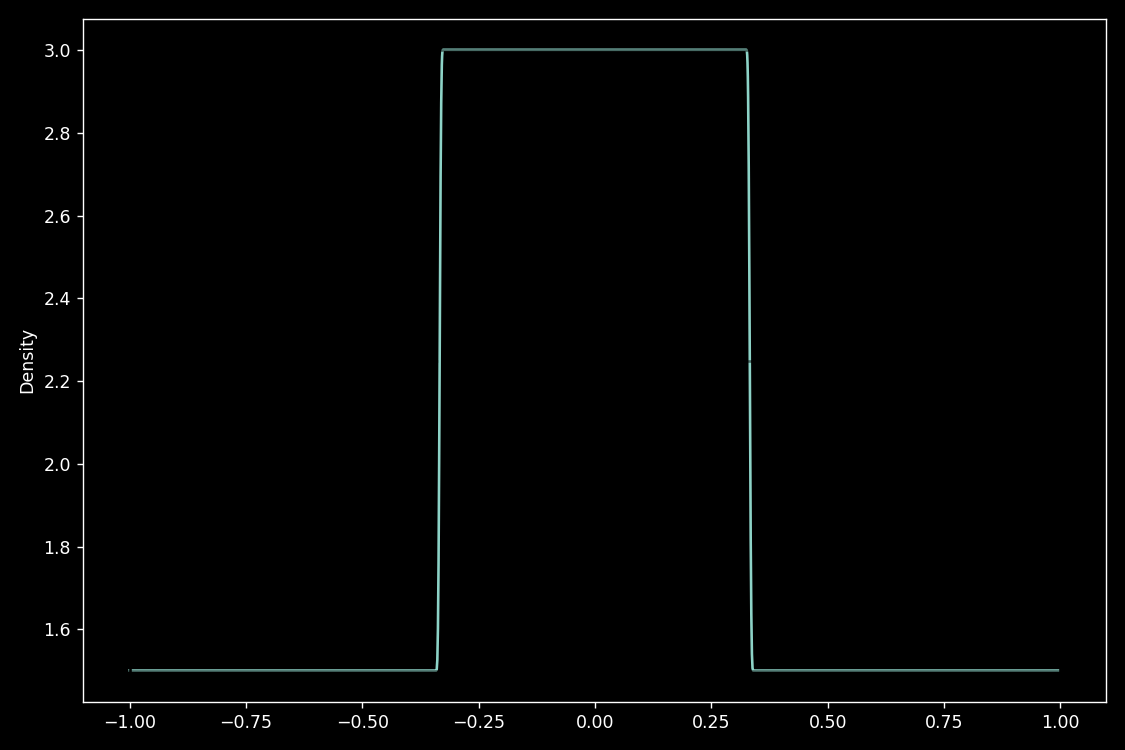

In [5]:
# sample the pdf using the inverse CFD, plotting shows the pdf
sampled = samplePDF(pdf, plot = False, numParticles = numParticles)
# sample positions according to the given pdf
fluidPositions = ((torch.tensor(sampled)/2 +0.5)* (maxDomain - minDomain) + minDomain)
# initially zero velocity everywhere
fluidVelocities = torch.zeros(fluidPositions.shape[0])
# and all particles with identical masses
fluidAreas = torch.ones_like(fluidPositions) * baseArea
# simulationStates holds all timestep information
simulationStates = []
# plot initial density field to show starting conditions
plotDensity(fluidPositions, fluidAreas, minDomain, maxDomain, particleSupport)

In [6]:
# run the simulation using RK4
for i in tqdm(range(timesteps)):
    # Compute state for substep 1
    v1 = torch.clone(fluidVelocities)
    # RK4 substep 1
    dudt_k1, dxdt_k1, fluidDensity, fluidPressure = computeUpdate(fluidPositions, fluidVelocities, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, dt)   
    # Compute state for substep 2
    x_k1 = fluidPositions + 0.5 * dt * dxdt_k1
    x_k1[x_k1 < minDomain] += maxDomain - minDomain
    x_k1[x_k1 > maxDomain] -= maxDomain - minDomain    
    u_k1 = fluidVelocities + 0.5 * dt * dudt_k1    
    # RK4 substep 2
    dudt_k2, dxdt_k2, _, _ = computeUpdate(x_k1, u_k1, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, 0.5 * dt)    
    # Compute state for substep 2
    x_k2 = fluidPositions + 0.5 * dt * dxdt_k2
    x_k2[x_k2 < minDomain] += maxDomain - minDomain
    x_k2[x_k2 > maxDomain] -= maxDomain - minDomain
    u_k2 = fluidVelocities + 0.5 * dt * dudt_k2
    # RK4 substep 3
    dudt_k3, dxdt_k3, _, _ = computeUpdate(x_k2, u_k2, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport,  0.5 * dt)    
    # Compute state for substep 4    
    x_k3 = fluidPositions + dt * dxdt_k3
    x_k3[x_k3 < minDomain] += maxDomain - minDomain
    x_k3[x_k3 > maxDomain] -= maxDomain - minDomain
    u_k3 = fluidVelocities + dt * dudt_k3
    # RK4 substep 4
    dudt_k4, dxdt_k4, _, _ = computeUpdate(x_k3, u_k3, fluidAreas, minDomain, maxDomain, kappa, restDensity, diffusionCoefficient, xsphConstant, particleSupport, dt)    
    # RK substeps done, store current simulation state for later processing/learning. density and pressure are based on substep 1 (i.e., the starting point for this timestep)
    simulationStates.append(torch.stack([fluidPositions, fluidVelocities, fluidDensity, fluidPressure, dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4), fluidAreas]))
    # time integration using RK4 for velocity
    fluidVelocities = fluidVelocities + dt/6 * (dudt_k1 + 2* dudt_k2 + 2 * dudt_k3 + dudt_k4)
    fluidPositions = fluidPositions + dt * fluidVelocities
    # enforce periodic boundary conditions
    fluidPositions[fluidPositions < minDomain] += maxDomain - minDomain
    fluidPositions[fluidPositions > maxDomain] -= maxDomain - minDomain
# After the simulation has run we stack all the states into one large array for easier slicing and analysis
simulationStates = torch.stack(simulationStates)

  0%|          | 0/2048 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


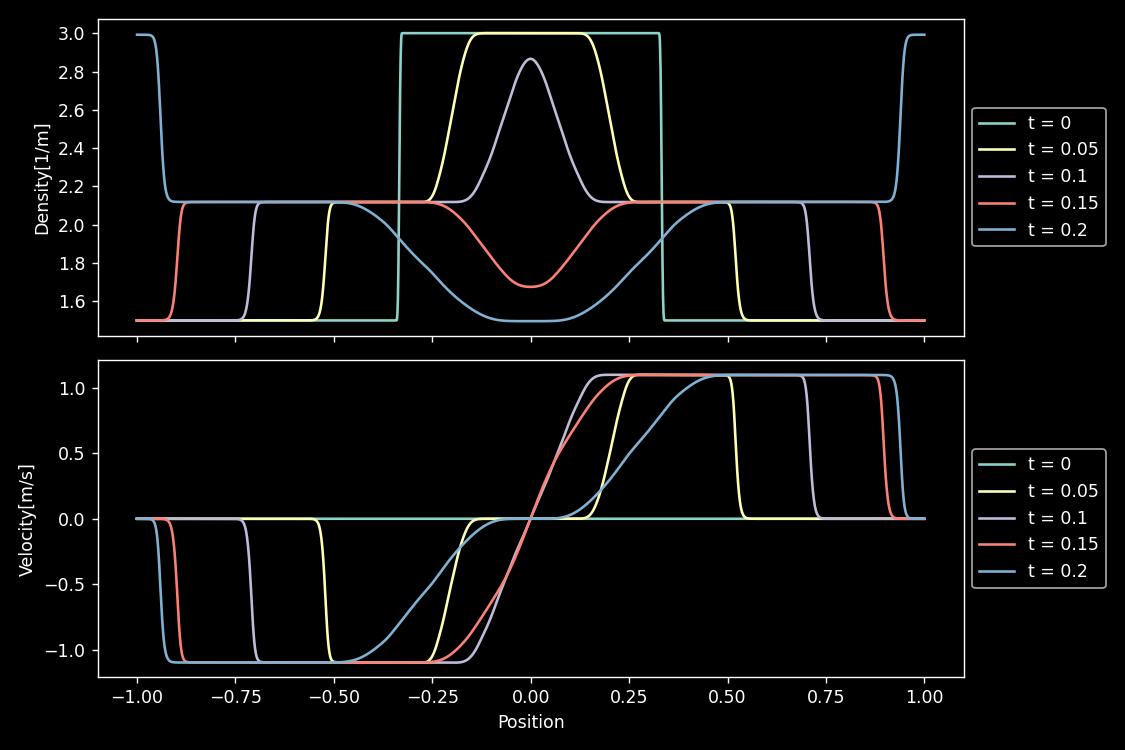

In [7]:
# Visualize simulation state for some example timesteps
plotSimulationState(simulationStates, minDomain, maxDomain, dt, timepoints = [0, 50, 100, 150, 200])

<IPython.core.display.Javascript object>


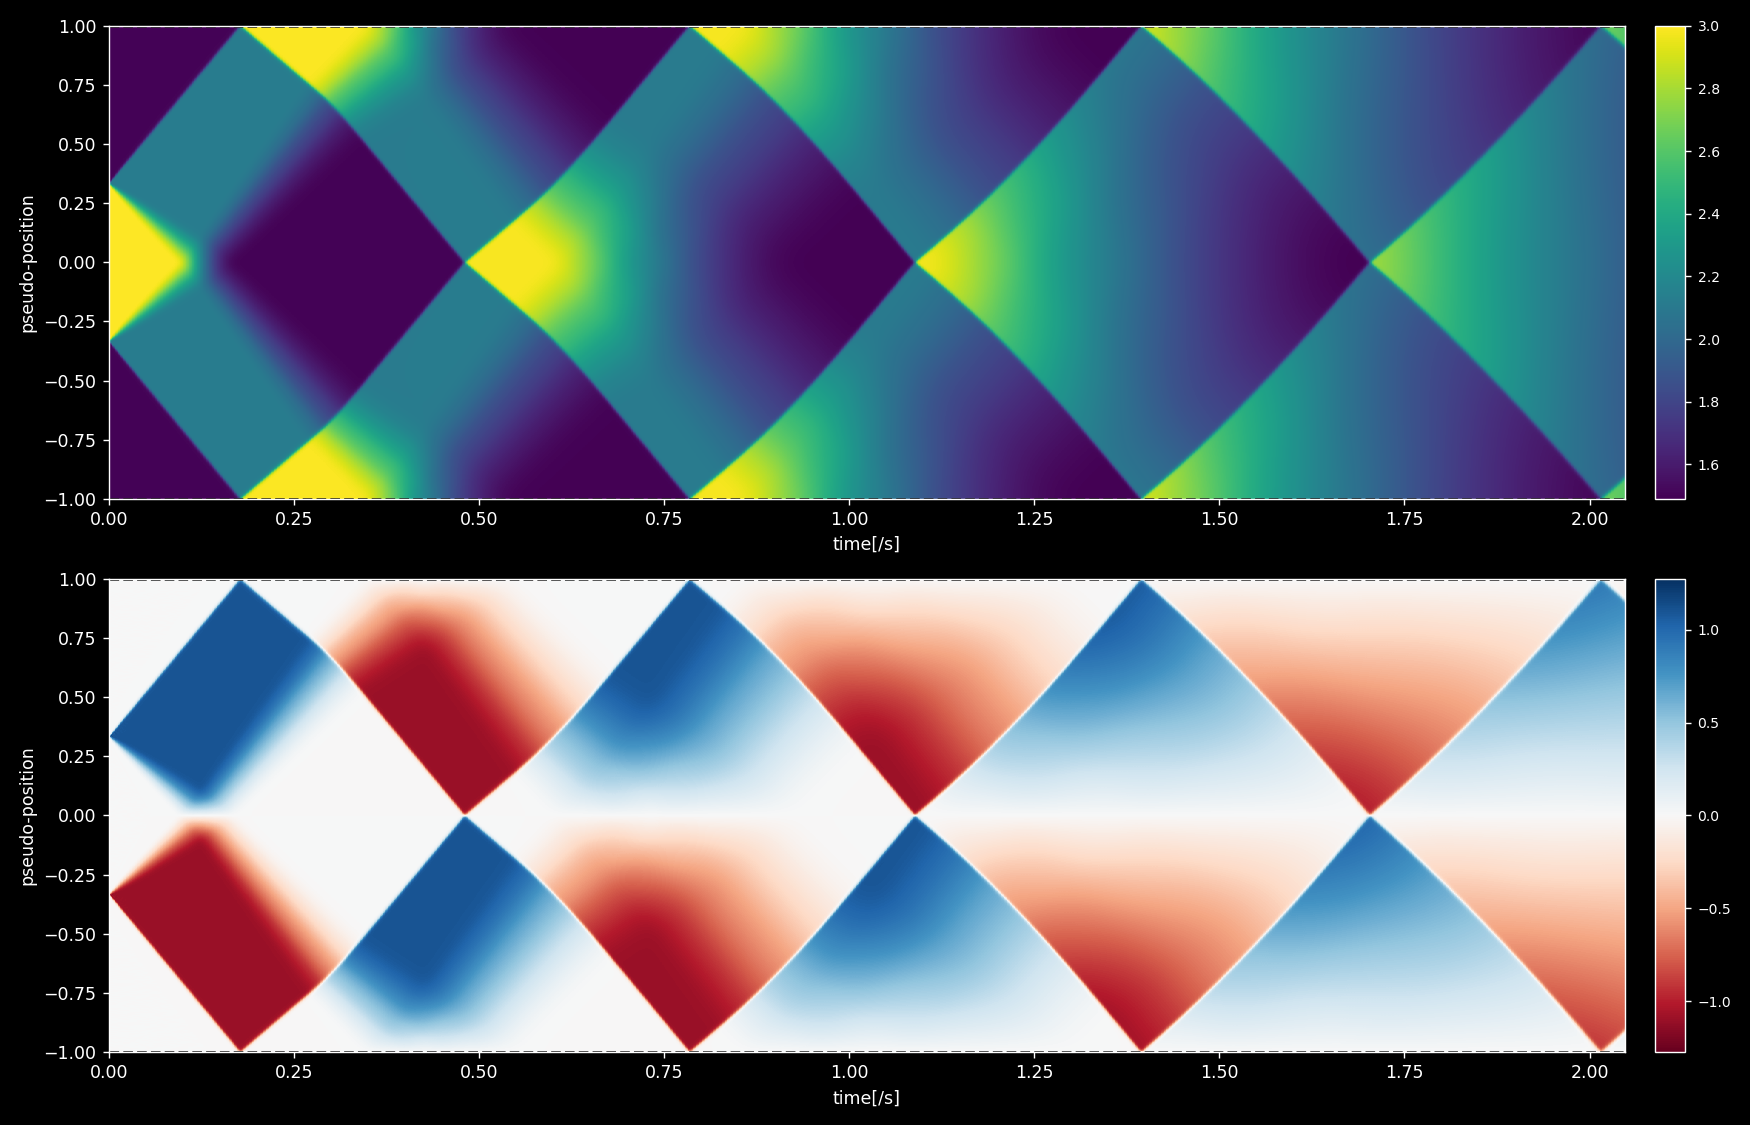

In [8]:
# Visualize the entire simulation, position on the y axis, time on the x axis
regularPlot(simulationStates, minDomain, maxDomain, dt, nx = numParticles, ny = timesteps)

In [9]:
ignoredTimesteps = 256
batchSize = 4 # training batch size
# Training done on all timesteps except the last ignoredTimesteps
timestamps = np.arange(0,simulationStates.shape[0] - ignoredTimesteps)

In [10]:
# create pytorch dataloader (via pytorch geometric for convenience)
dataLoader = DataLoader(timestamps, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)

In [11]:
# example on how to load from a batch and compute the density of the batch and comparing the computed density with the 'ground truth' coming from the simulation
# bdata = next(dataIter)
# positions = [simulationStates[i,0,:] for i in bdata]
# areas = [simulationStates[i,-1,:] for i in bdata]
# velocities = [simulationStates[i,1,:] for i in bdata]
# updates = [simulationStates[i,-2,:] for i in bdata]
# print(positions)
# ghosts = [createGhostParticles(p, minDomain, maxDomain) for p in positions]
# print(ghosts)
# neighborInformation = [findNeighborhoods(p, g, particleSupport) for p,g in zip(positions, ghosts)]
# neighbors = [n[0] for n in neighborInformation]
# radialDistances = [n[1] for n in neighborInformation]
# distances = [n[2] for n in neighborInformation]
# print(neighbors)
# densities = [computeDensity(p, a, particleSupport, r, n) for p,a,r,n in zip(positions,areas,radialDistances, neighbors)]
# gtDensity = [simulationStates[i,2,:] for i in bdata]
# err = torch.hstack([torch.mean((rho - gt)**2) for rho,gt in zip(densities, gtDensity)])
# print(err)

In [17]:
# iterative training script, lifted from some other code of mine for convenience
def processDataLoaderIter(iterations, e, rollout, ds, dataLoader, dataIter, model, optimizer, train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01):
    with record_function("process data loader"): 
        losses = []
        batchIndices = []
        weights = []

        if train:
            model.train(True)
        else:
            model.train(False)

        i = 0
        for b in (pbl := tqdm(range(iterations), leave=False)):
            # get next batch from dataLoader, if all batches have been processed get a new iterator (which shuffles the batch order)
            try:
                bdata = next(dataIter)
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)
            # the actual batch processing step
            with record_function("process data loader[batch]"): 
                # reset optimizer gradients
                if train:
                    optimizer.zero_grad()
                # load data for batch
                positions = [simulationStates[i,0,:] for i in bdata]
                areas = [simulationStates[i,-1,:] for i in bdata]
                velocities = [simulationStates[i,1,:] for i in bdata]
                updates = [simulationStates[i,-2,:] for i in bdata]
                # compute ghost particles for batch for neighborhood search
                ghosts = [createGhostParticles(p, minDomain, maxDomain) for p in positions]
                # perform neighborhood search for batch and split the data into 3 separate lists
                neighborInformation = [findNeighborhoods(p, g, particleSupport) for p,g in zip(positions, ghosts)]
                neighbors = [n[0] for n in neighborInformation]
                radialDistances = [n[1] for n in neighborInformation]
                distances = [n[2] for n in neighborInformation]
                # compute the density on the given batch data
                densities = [computeDensity(p, a, particleSupport, r, n) for p,a,r,n in zip(positions,areas,radialDistances, neighbors)]
                # all data so far is in lists of equal length, merge lists with special attention to the neighborlist to make sure indices are pointing to the correct particles
                stackedPositions = torch.hstack(positions).type(torch.float32)
                stackedAreas = torch.hstack(areas).type(torch.float32)
                stackedVelocities = torch.hstack(velocities).type(torch.float32)
                stackedUpdates = torch.hstack(updates).type(torch.float32)
                stackedNeighbors = torch.hstack([i * positions[0].shape[0] + neighbors[i] for i in range(len(neighbors))])
                stackedRadialDistances = torch.hstack(radialDistances).type(torch.float32)
                stackedDistances = torch.hstack(distances).type(torch.float32)
                stackedDensities = torch.hstack(densities).type(torch.float32)
                # tensor of ones to make learning easier
                ones = torch.ones_like(stackedAreas)
                # compute the signed distances needed for the network layer, uses the radialDistances and directions computed before                
                d = stackedRadialDistances[:,None] * torch.sign(stackedDistances[:,None])
                # run the network layer
                prediction = model((ones[:,None], ones[:,None]), stackedNeighbors, d)
                # simple L2 loss (no sqrt for stability purposes, as usual)
                loss = torch.mean((prediction - torch.hstack(densities)[:,None])**2)
                # store the losses for later processing
                losses.append(((prediction - torch.hstack(densities)[:,None])**2).detach().cpu().numpy())
                # store the current weights before the update
                weights.append(torch.clone(model.weight.detach().cpu()).numpy())
                # update the network weights
                if train:
                    loss.backward()
                    optimizer.step()
                # create some information to put on the tqdm progress bars
                batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))
                pbl.set_description('%8s[gpu %d]: %3d [%1d] @ %1.1e: :  %s -> %.2e' %(prefix, 0, e, 0, lr, batchString, loss.detach().cpu().numpy()))
                pb.set_description('[gpu %d] %90s - Learning: %1.4e' %(0, "", np.mean(np.vstack(losses))))
                pb.update()
                batchIndices.append(bdata)
        # stack the processed batches and losses for further processing
        bIndices  = np.hstack(batchIndices)
#         losses = np.vstack(losses)
#         losses = np.vstack(losses)
        # and return
        return bIndices, losses, weights

In [18]:
# useful function for learning, returns non normalized windows
def getWindowFunction(windowFunction):
    windowFn = lambda r: torch.ones_like(r)
    if windowFunction == 'cubicSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3 - 4 * torch.clamp(1/2 - r, min = 0) ** 3
    if windowFunction == 'quarticSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 4 - 5 * torch.clamp(3/5 - r, min = 0) ** 4 + 10 * torch.clamp(1/5- r, min = 0) ** 4
    if windowFunction == 'quinticSpline':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 5 - 6 * torch.clamp(2/3 - r, min = 0) ** 5 + 15 * torch.clamp(1/3 - r, min = 0) ** 5
    if windowFunction == 'Wendland2_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3 * (1 + 3 * r)
    if windowFunction == 'Wendland4_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 5 * (1 + 5 * r + 8 * r**2)
    if windowFunction == 'Wendland6_1D':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 7 * (1 + 7 * r + 19 * r**2 + 21 * r**3)
    if windowFunction == 'Wendland2':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 4 * (1 + 4 * r)
    if windowFunction == 'Wendland4':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 6 * (1 + 6 * r + 35/3 * r**2)
    if windowFunction == 'Wendland6':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 8 * (1 + 8 * r + 25 * r**2 + 32 * r**3)
    if windowFunction == 'Hoct4':
        def hoct4(x):
            alpha = 0.0927 # Subject to 0 = (1 − α)** nk−2 + A(γ − α)**nk−2 + B(β − α)**nk−2
            beta = 0.5 # Free parameter
            gamma = 0.75 # Free parameter
            nk = 4 # order of kernel

            A = (1 - beta**2) / (gamma ** (nk - 3) * (gamma ** 2 - beta ** 2))
            B = - (1 + A * gamma ** (nk - 1)) / (beta ** (nk - 1))
            P = -nk * (1 - alpha) ** (nk - 1) - nk * A * (gamma - alpha) ** (nk - 1) - nk * B * (beta - alpha) ** (nk - 1)
            Q = (1 - alpha) ** nk + A * (gamma - alpha) ** nk + B * (beta - alpha) ** nk - P * alpha

            termA = P * x + Q
            termB = (1 - x) ** nk + A * (gamma - x) ** nk + B * (beta - x) ** nk
            termC = (1 - x) ** nk + A * (gamma - x) ** nk
            termD = (1 - x) ** nk
            termE = 0 * x

            termA[x > alpha] = 0
            termB[x <= alpha] = 0
            termB[x > beta] = 0
            termC[x <= beta] = 0
            termC[x > gamma] = 0
            termD[x <= gamma] = 0
            termD[x > 1] = 0
            termE[x < 1] = 0

            return termA + termB + termC + termD + termE

        windowFn = lambda r: hoct4(r)
    if windowFunction == 'Spiky':
        windowFn = lambda r: torch.clamp(1 - r, min = 0) ** 3
    if windowFunction == 'Mueller':
        windowFn = lambda r: torch.clamp(1 - r ** 2, min = 0) ** 3
    if windowFunction == 'poly6':
        windowFn = lambda r: torch.clamp((1 - r)**3, min = 0)
    if windowFunction == 'Parabola':
        windowFn = lambda r: torch.clamp(1 - r**2, min = 0)
    if windowFunction == 'Linear':
        windowFn = lambda r: torch.clamp(1 - r, min = 0)
    return windowFn

In [19]:
# Hyperparameters for the NN
lr = 1e-2 # Learning rate
iterations = 100 # update iterations per epoch
epochs = 10 # total number of epochs, LR is halved every epoch
n = 16 # number of weights per continuous convolution
basis = 'linear' # basis for the convolution, set to linear for CConv
computeBatchSize = 128 # higher number = faster processing but more memory consumption (not relevant for small simulations)
windowFn = getWindowFunction('Wendland2_1D') # window function that is applied after each network layer
windowFn = None # set to None for now
normalized = False # rbf normalization, can be safely ignored

In [20]:
# Setup a single layer using the rbf convolution (which is a generalized CConv)
model = RbfConv(
            in_channels = 1, out_channels = 1,
                dim = 1, size = [n],
                rbf = basis,
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = 'cartesian',
                batch_size = [computeBatchSize, computeBatchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized)
# Adjusting the weight initialization for testing out things, defaults to uniform -0.05 to 0.05 as per the CConv paper
torch.nn.init.uniform_(model.weight,0.0,0.3)
# Create optimizer for the single layer
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)

In [21]:
# create progress bar and arrays to hold the learning progress
pb = tqdm(range(epochs * iterations))
lossArray = []
batches = []
weights = []
# the actual learning process
for epoch in range(epochs):
    losses = []

    b, l, w = processDataLoaderIter(iterations, epoch, epoch // 2 + 1, None, dataLoader, dataIter, model, optimizer, True, prefix = 'training', augmentAngle=False, augmentJitter=False, jitterAmount=0.01)
    lossArray.append(l)
    batches.append(b)
    weights.append(w)
    if epoch % 1 == 0 and epoch > 0:
        lr = lr * 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


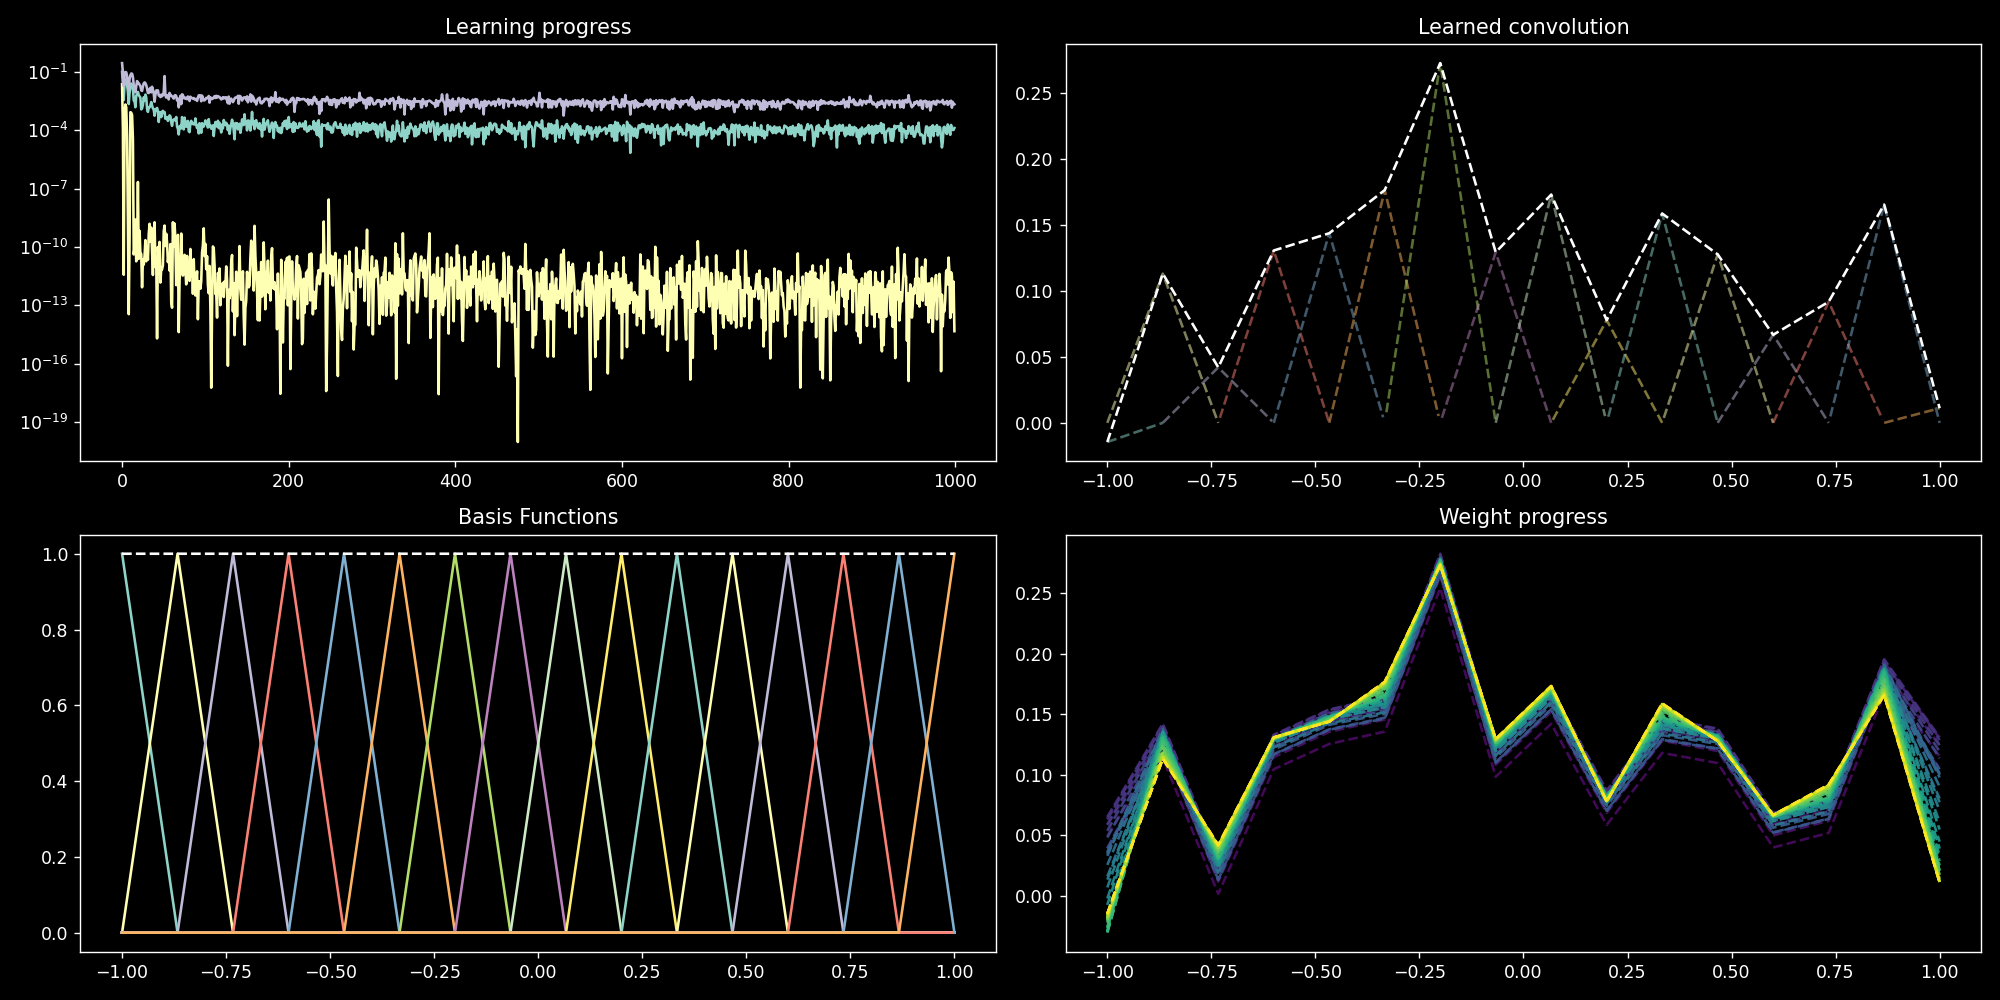

In [22]:
# Plot the learned convolution (only works for single layer models (for now))
fig, axis = plt.subplots(2, 2, figsize=(16,8), sharex = False, sharey = False, squeeze = False)
x =  torch.linspace(-1,1,511)
# internal function that is used for the rbf convolution
fx = evalBasisFunction(n, x , which = basis, periodic=False)
fx = fx / torch.sum(fx, axis = 0)[None,:] if normalized else fx # normalization step
# plot the individual basis functions with a weight of 1
for y in range(n):
    axis[1,0].plot(x, fx[y,:], label = '$f_%d(x)$' % y)
# plot the overall convolution basis for all weights equal to 1
axis[1,0].plot(x,torch.sum(fx, axis=0),ls='--',c='white', label = '$\Sigma_i f_i(x)$')
# axis[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=5, fancybox=True, shadow=False)
axis[1,0].set_title('Basis Functions')

# plot the individual basis functions with the learned weights
for y in range(n):
    fy = model.weight[:,0][y].detach() * fx[y,:]
    axis[0,1].plot(x[fy != 0], fy[fy != 0], label = '$w_d f_%d(x)$' % y, ls = '--', alpha = 0.5)
axis[0,1].plot(x,torch.sum(model.weight[:,0].detach() * fx,axis=0),ls='--',c='white', label = '$\Sigma_i w_i f_i(x)$')
# axis[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=5, fancybox=True, shadow=False)
axis[0,1].set_title('Learned convolution')

batchedLosses = np.stack(lossArray, axis = 0).reshape(iterations * epochs, numParticles * batchSize)
axis[0,0].set_title('Learning progress')
axis[0,0].semilogy(np.mean(batchedLosses, axis = 1))
axis[0,0].semilogy(np.min(batchedLosses, axis = 1))
axis[0,0].semilogy(np.max(batchedLosses, axis = 1))

cm = mpl.colormaps['viridis']

steps = iterations * epochs
ls = np.logspace(0, np.log10(steps), num =  50)
ls = [int(np.floor(f)) for f in ls]
ls = np.unique(ls).tolist()

c = 0
for i in range(epochs):
    for j in range(iterations):
        c = c + 1        
        if c + 1 in ls:
            axis[1,1].plot(x,torch.sum(torch.tensor(weights[i][j][:,0]) * fx,axis=0),ls='--',c= cm(ls.index(c+1) / (len(ls) - 1)), alpha = 0.95)
axis[1,1].set_title('Weight progress')
fig.tight_layout()   

In [23]:
# Visualize the 'testing data', i.e., the ignoredTimesteps at the end of the simulation
# no gradient tracking here for memory conservation
with torch.no_grad():
    # same procedure as in the training
    bdata = np.arange(len(simulationStates) - ignoredTimesteps, len(simulationStates))
    positions = [simulationStates[i,0,:] for i in bdata]
    areas = [simulationStates[i,-1,:] for i in bdata]
    velocities = [simulationStates[i,1,:] for i in bdata]
    updates = [simulationStates[i,-2,:] for i in bdata]
    ghosts = [createGhostParticles(p, minDomain, maxDomain) for p in positions]
    neighborInformation = [findNeighborhoods(p, g, particleSupport) for p,g in zip(positions, ghosts)]
    neighbors = [n[0] for n in neighborInformation]
    radialDistances = [n[1] for n in neighborInformation]
    distances = [n[2] for n in neighborInformation]
    densities = [computeDensity(p, a, particleSupport, r, n) for p,a,r,n in zip(positions,areas,radialDistances, neighbors)]

    stackedPositions = torch.hstack(positions).type(torch.float32)
    stackedAreas = torch.hstack(areas).type(torch.float32)
    stackedVelocities = torch.hstack(velocities).type(torch.float32)
    stackedUpdates = torch.hstack(updates).type(torch.float32)
    stackedNeighbors = torch.hstack([i * positions[0].shape[0] + neighbors[i] for i in range(len(neighbors))])
    stackedRadialDistances = torch.hstack(radialDistances).type(torch.float32)
    stackedDistances = torch.hstack(distances).type(torch.float32)
    stackedDensities = torch.hstack(densities).type(torch.float32)
    
    ones = torch.ones_like(stackedAreas)
    d = stackedRadialDistances[:,None] * torch.sign(stackedDistances[:,None])
    
    prediction = model((ones[:,None], ones[:,None]), stackedNeighbors, d)
#     loss = torch.mean((prediction - torch.hstack(densities)[:,None])**2)

<IPython.core.display.Javascript object>


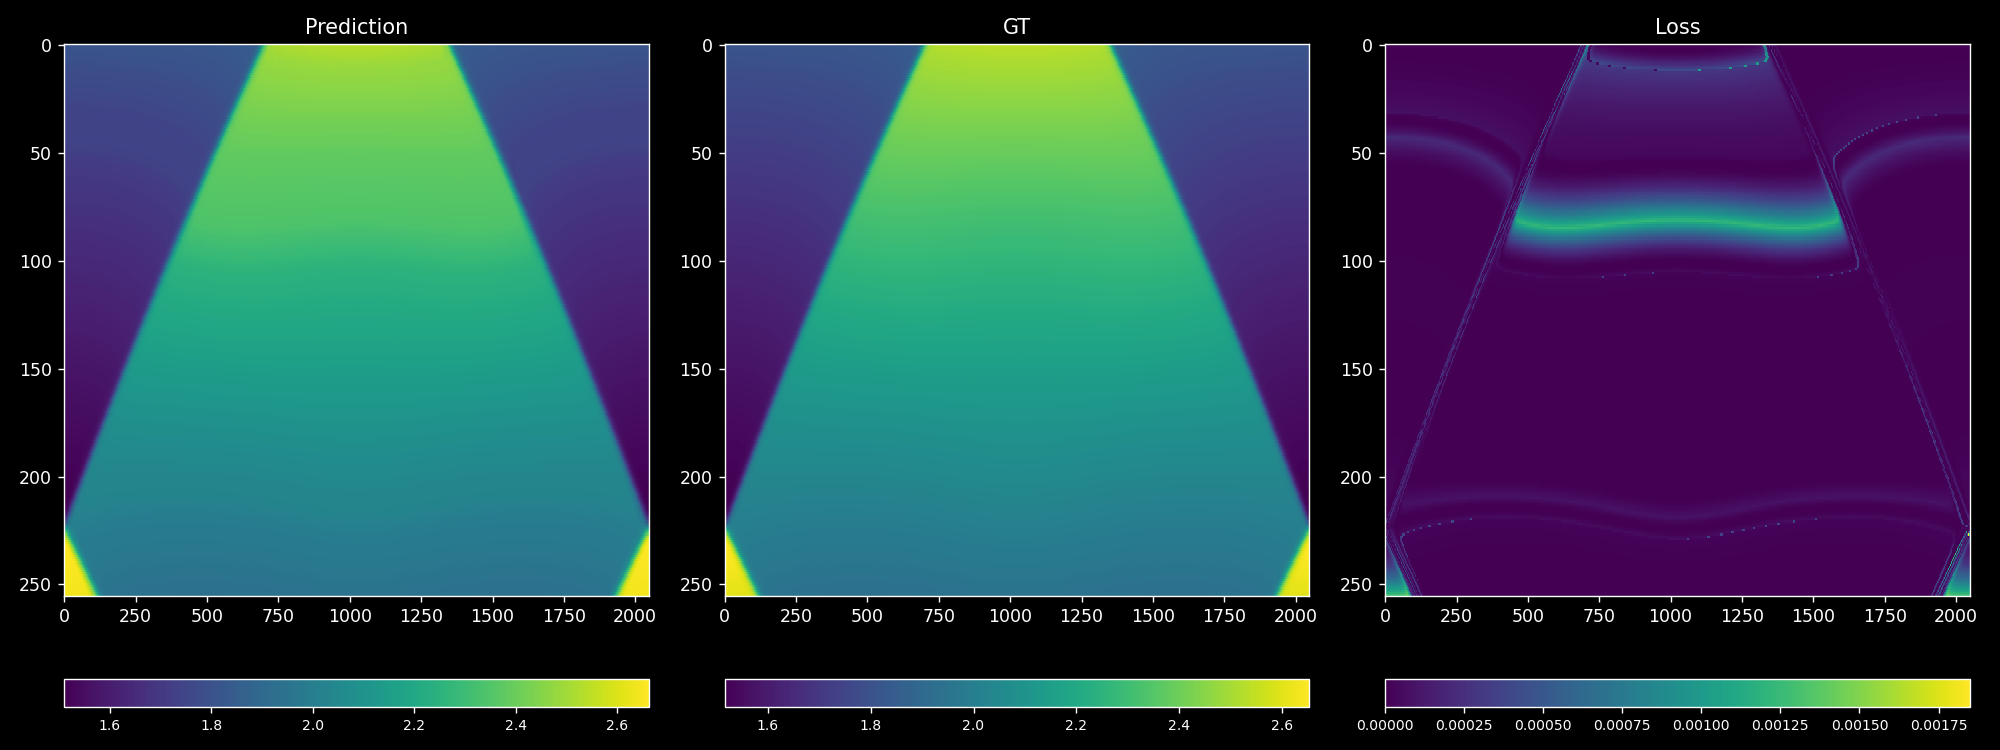

In [24]:
# Plot the 'testing' data
fig, axis = plt.subplots(1, 3, figsize=(16,6), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('Prediction') 
im = axis[0,0].imshow(prediction.reshape((bdata.shape[0], positions[0].shape[0])), interpolation = 'nearest') # uses some matrix reshaping to undo the hstack
axis[0,0].axis('auto')
ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
cbarPredFFT = fig.colorbar(im, cax=cax1,orientation='horizontal')
cbarPredFFT.ax.tick_params(labelsize=8) 

axis[0,1].set_title('GT')
im = axis[0,1].imshow(torch.hstack(densities).reshape((bdata.shape[0], positions[0].shape[0])), interpolation = 'nearest')
axis[0,1].axis('auto')
ax1_divider = make_axes_locatable(axis[0,1])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
cbarPredFFT = fig.colorbar(im, cax=cax1,orientation='horizontal')
cbarPredFFT.ax.tick_params(labelsize=8) 

axis[0,2].set_title('Loss')
im = axis[0,2].imshow(((prediction - torch.hstack(densities)[:,None])**2).reshape((bdata.shape[0], positions[0].shape[0])), interpolation = 'nearest')
axis[0,2].axis('auto')
ax1_divider = make_axes_locatable(axis[0,2])
cax1 = ax1_divider.append_axes("bottom", size="5%", pad="15%")
cbarPredFFT = fig.colorbar(im, cax=cax1,orientation='horizontal')
cbarPredFFT.ax.tick_params(labelsize=8) 

fig.tight_layout()